https://ys-cs17.tistory.com/25  
https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py  
https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/ResNet18_CIFAR10_Train.ipynb  
https://git.dst.etit.tu-chemnitz.de/external/tf-models/-/blob/1d057dfc32f515a63ab1e23fd72052ab2a954952/official/vision/image_classification/resnet_model.py  

# Going Deeper 01. ResNet Ablation Study
--------
## [루브릭]

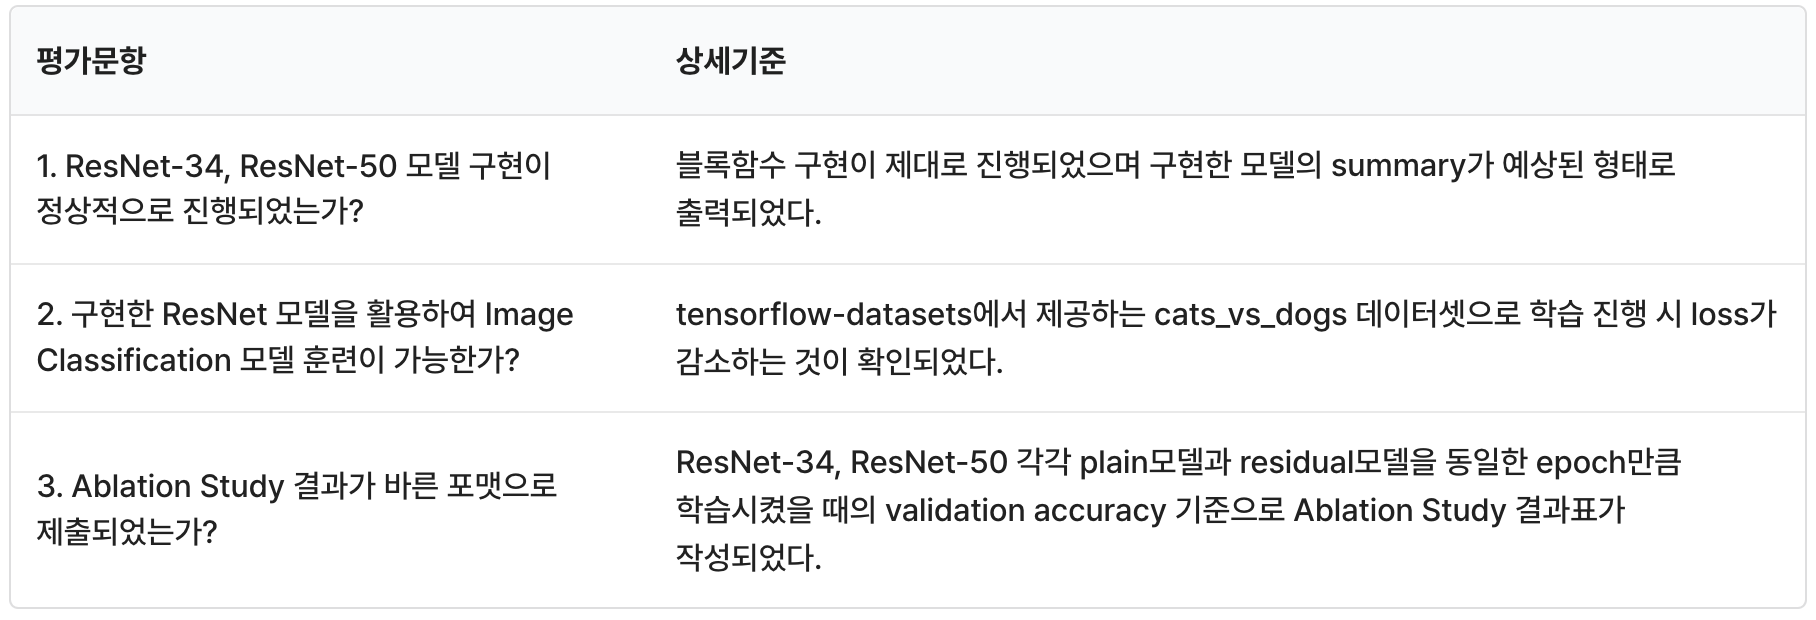

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.keras.backend.clear_session()

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' ## 초기화할 GPU number

with tf.Graph().as_default():
	# GPU 메모리를 전부 할당하지 않고, 아주 적은 비율만 할당되어 시작됨. 프로세스의 메모리 수요에 따라 자동적으로 증가
	# 단, GPU 메모리를 처음부터 전체 비율을 사용하지 않음
	gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)

In [6]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [9]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [10]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_validation))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


In [11]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
ds_info.features["label"].num_classes

2

In [14]:
ds_info.features["label"].names

['cat', 'dog']

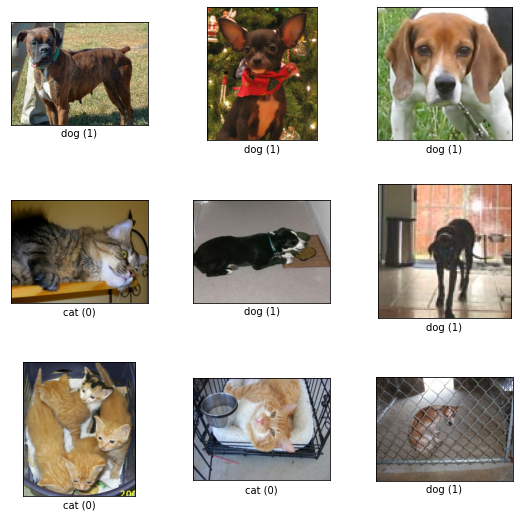

In [15]:
fig = tfds.show_examples(ds_train, ds_info)

In [16]:
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

In [17]:
# is_50 : True => resnet_50
# is_plain : True => no skip connection
# original skip connection
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=0, is_50=False, is_plain=False):
    # 입력 레이어
    x = input_layer
    
    # CNN 레이어
    if not is_50:
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  
#             x = keras.layers.Conv2D(
#                 filters=channel,
#                 kernel_size=(3,3),
#                 kernel_initializer='he_normal',
#                 padding='same',
#                 name=f'block{block_num}_0_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)
            
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            
            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]
                
#                 if shortcut_channel != channel:
#                     shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_2_shortcut{cnn_num}')(shortcut)
#                     shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)

                if (shortcut_channel != channel) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(shortcut)                    
                    
                    
                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_2_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
            
            else:
                x = keras.layers.Activation('relu', name=f'block{block_num}_2_relu{cnn_num}')(x)
    
    else :
        for cnn_num in range(num_cnn):
            shortcut = x
            if (block_num != 0) and (cnn_num == 0):
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(2,2),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)

            else:
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    strides=(1,1),
                    kernel_initializer='he_normal',
                    padding='valid',
                    name=f'block{block_num}_0_conv{cnn_num}')(x)  
 
            x = keras.layers.BatchNormalization(name=f'block{block_num}_0_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_0_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_1_bn{cnn_num}')(x)
            x = keras.layers.Activation('relu', name=f'block{block_num}_1_relu{cnn_num}')(x)

            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='valid',
                name=f'block{block_num}_2_conv{cnn_num}')(x)
            x = keras.layers.BatchNormalization(name=f'block{block_num}_2_bn{cnn_num}')(x)        

            if not is_plain:
                shortcut_channel = shortcut.shape.as_list()[-1]

                if (shortcut_channel != channel*4) and (block_num == 0) and (cnn_num == 0):
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(1,1), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)                    
                    
                elif (shortcut_channel != channel*4) and (block_num != 0) and (cnn_num == 0):    
                    shortcut = keras.layers.Conv2D(channel*4, kernel_size=(1,1), strides=(2,2), padding='valid', name=f'block{block_num}_3_shortcut{cnn_num}')(shortcut)
                    shortcut = keras.layers.BatchNormalization(name=f'block{block_num}_3_bn{cnn_num}')(shortcut)

                # skip connection
                x = keras.layers.Add(name=f'block{block_num}_3_add{cnn_num}')([x, shortcut])
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)

            else :
                x = keras.layers.Activation('relu', name=f'block{block_num}_3_relu{cnn_num}')(x)
        
    return x

In [18]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
res_block_output = build_resnet_block(resnet_input_layer)    # resnet block 생성

In [19]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=res_block_output)  
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block0_0_conv0 (Conv2D)         (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
block0_0_bn0 (BatchNormalizatio (None, 32, 32, 64)   256         block0_0_conv0[0][0]             
__________________________________________________________________________________________________
block0_0_relu0 (Activation)     (None, 32, 32, 64)   0           block0_0_bn0[0][0]               
______________________________________________________________________________________________

In [20]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=2, is_50=False, is_plain=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # conv 1층
    output = keras.layers.Conv2D(filters=channel_list[0],
                                kernel_size=(7,7),
                                strides=(2,2),
                                padding='same',
                                kernel_initializer='he_normal')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    
    # conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i, 
            is_50=is_50
        )
        
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='tanh', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [21]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_50 = build_resnet(is_50=True)

resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [22]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
resnet_34 = build_resnet()

resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [23]:
BATCH_SIZE = 64
EPOCH = 30

In [24]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_validation = apply_normalize_on_dataset(ds_validation, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [25]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 61/290 [=====>........................] - ETA: 11s - loss: 7.3357 - accuracy: 0.5044

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 11s - loss: 7.3355 - accuracy: 0.5051

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 11s - loss: 7.3679 - accuracy: 0.5047

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 10s - loss: 7.4344 - accuracy: 0.5050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


187/290 [==================>...........] - ETA: 5s - loss: 7.5342 - accuracy: 0.5020

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 7.5446 - accuracy: 0.5032

212/290 [====================>.........] - ETA: 4s - loss: 7.5493 - accuracy: 0.5031

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 7.5436 - accuracy: 0.5036

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.5558 - accuracy: 0.5030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 38s 84ms/step - loss: 7.5558 - accuracy: 0.5030 - val_loss: 7.9418 - val_accuracy: 0.4775


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 2/30
 62/290 [=====>........................] - ETA: 11s - loss: 7.6619 - accuracy: 0.5103

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 11s - loss: 7.6741 - accuracy: 0.5115

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 10s - loss: 7.6701 - accuracy: 0.5087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 10s - loss: 7.7485 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 4s - loss: 7.7237 - accuracy: 0.4962

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 7.7136 - accuracy: 0.4980

214/290 [=====================>........] - ETA: 3s - loss: 7.7271 - accuracy: 0.4977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 2s - loss: 7.6611 - accuracy: 0.5011

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6725 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6725 - accuracy: 0.5017 - val_loss: 8.1557 - val_accuracy: 0.4810


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 3/30
 64/290 [=====>........................] - ETA: 11s - loss: 7.5656 - accuracy: 0.5066

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 70/290 [======>.......................] - ETA: 11s - loss: 7.5885 - accuracy: 0.5047

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 11s - loss: 7.6110 - accuracy: 0.5019

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 7.6796 - accuracy: 0.4986

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 4s - loss: 7.6951 - accuracy: 0.5009

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 7.7044 - accuracy: 0.5002

215/290 [=====================>........] - ETA: 3s - loss: 7.6979 - accuracy: 0.5012

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 7.6673 - accuracy: 0.5016

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 7.6507 - accuracy: 0.5012

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6526 - accuracy: 0.5010 - val_loss: 8.1945 - val_accuracy: 0.4774


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 4/30
 65/290 [=====>........................] - ETA: 11s - loss: 7.6420 - accuracy: 0.5012

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 11s - loss: 7.7023 - accuracy: 0.4965

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 7.6874 - accuracy: 0.4978

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 10s - loss: 7.6475 - accuracy: 0.5023

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


194/290 [===================>..........] - ETA: 4s - loss: 7.7025 - accuracy: 0.4994

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 7.7021 - accuracy: 0.5005

216/290 [=====================>........] - ETA: 3s - loss: 7.7125 - accuracy: 0.4996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 2s - loss: 7.7298 - accuracy: 0.4983

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.7208 - accuracy: 0.4988

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.7208 - accuracy: 0.4988 - val_loss: 8.0182 - val_accuracy: 0.5000


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 5/30
 66/290 [=====>........................] - ETA: 11s - loss: 7.7784 - accuracy: 0.4869

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 11s - loss: 7.7431 - accuracy: 0.4894

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 7.7439 - accuracy: 0.4917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 10s - loss: 7.6912 - accuracy: 0.4986

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 7.6743 - accuracy: 0.5006

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 7.6976 - accuracy: 0.4994

217/290 [=====================>........] - ETA: 3s - loss: 7.7047 - accuracy: 0.4993

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 7.6858 - accuracy: 0.5006

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6825 - accuracy: 0.5001

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6825 - accuracy: 0.5001 - val_loss: 7.9468 - val_accuracy: 0.4957


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 6/30
 66/290 [=====>........................] - ETA: 11s - loss: 7.4569 - accuracy: 0.5133

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 11s - loss: 7.4847 - accuracy: 0.5137

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 10s - loss: 7.4898 - accuracy: 0.5123

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 10s - loss: 7.4662 - accuracy: 0.5112

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 4s - loss: 7.5779 - accuracy: 0.5046

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 7.6084 - accuracy: 0.5036

218/290 [=====================>........] - ETA: 3s - loss: 7.5986 - accuracy: 0.5043

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


253/290 [=========================>....] - ETA: 1s - loss: 7.5753 - accuracy: 0.5049

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.5886 - accuracy: 0.5024

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.5886 - accuracy: 0.5024 - val_loss: 7.9401 - val_accuracy: 0.4935
Epoch 7/30
 68/290 [======>.......................] - ETA: 11s - loss: 7.4991 - accuracy: 0.5023

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 11s - loss: 7.5785 - accuracy: 0.5004

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 10s - loss: 7.5761 - accuracy: 0.5010

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 10s - loss: 7.5566 - accuracy: 0.5027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 4s - loss: 7.6126 - accuracy: 0.5024

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 7.6200 - accuracy: 0.5016

219/290 [=====================>........] - ETA: 3s - loss: 7.6210 - accuracy: 0.5016

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 7.6250 - accuracy: 0.5020

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6392 - accuracy: 0.5011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6392 - accuracy: 0.5011 - val_loss: 8.0262 - val_accuracy: 0.4841


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 8/30
 69/290 [======>.......................] - ETA: 11s - loss: 7.4749 - accuracy: 0.5043

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 11s - loss: 7.4907 - accuracy: 0.5035

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 7.5498 - accuracy: 0.5018

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 10s - loss: 7.5207 - accuracy: 0.5035

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


199/290 [===================>..........] - ETA: 4s - loss: 7.6228 - accuracy: 0.5030

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 7.5970 - accuracy: 0.5053

220/290 [=====================>........] - ETA: 3s - loss: 7.5974 - accuracy: 0.5052

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


255/290 [=========================>....] - ETA: 1s - loss: 7.6595 - accuracy: 0.5021

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6634 - accuracy: 0.5003

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6634 - accuracy: 0.5003 - val_loss: 7.9307 - val_accuracy: 0.4965


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 9/30
 70/290 [======>.......................] - ETA: 11s - loss: 7.6126 - accuracy: 0.5009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 76/290 [======>.......................] - ETA: 11s - loss: 7.5793 - accuracy: 0.5029

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 7.5420 - accuracy: 0.5036

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 10s - loss: 7.5484 - accuracy: 0.5035

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 7.6799 - accuracy: 0.5003

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 7.6822 - accuracy: 0.4987

220/290 [=====================>........] - ETA: 3s - loss: 7.6807 - accuracy: 0.4977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 7.6459 - accuracy: 0.5002

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6784 - accuracy: 0.4984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6784 - accuracy: 0.4984 - val_loss: 7.8196 - val_accuracy: 0.4987


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 10/30
 71/290 [======>.......................] - ETA: 11s - loss: 7.6376 - accuracy: 0.5046

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 11s - loss: 7.6779 - accuracy: 0.5031

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 7.6746 - accuracy: 0.5017

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 7.6370 - accuracy: 0.5010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


200/290 [===================>..........] - ETA: 4s - loss: 7.4866 - accuracy: 0.5099

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 7.4956 - accuracy: 0.5094

222/290 [=====================>........] - ETA: 3s - loss: 7.4982 - accuracy: 0.5102

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 7.5422 - accuracy: 0.5068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.5468 - accuracy: 0.5062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.5468 - accuracy: 0.5062 - val_loss: 7.8196 - val_accuracy: 0.5082


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 11/30
 72/290 [======>.......................] - ETA: 11s - loss: 7.8229 - accuracy: 0.4948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 11s - loss: 7.7897 - accuracy: 0.4976

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 10s - loss: 7.7871 - accuracy: 0.5004

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 7.7671 - accuracy: 0.5010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 7.7340 - accuracy: 0.4987

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 7.7202 - accuracy: 0.4983

222/290 [=====================>........] - ETA: 3s - loss: 7.7212 - accuracy: 0.4985

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 7.6799 - accuracy: 0.5016

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.7391 - accuracy: 0.4991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.7391 - accuracy: 0.4991 - val_loss: 8.1075 - val_accuracy: 0.4857


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 12/30
 73/290 [======>.......................] - ETA: 11s - loss: 7.6894 - accuracy: 0.4959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 11s - loss: 7.6599 - accuracy: 0.4972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 10s - loss: 7.6321 - accuracy: 0.4985

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 9s - loss: 7.6727 - accuracy: 0.4976 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


202/290 [===================>..........] - ETA: 4s - loss: 7.6242 - accuracy: 0.5021

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 7.6112 - accuracy: 0.5025

224/290 [======================>.......] - ETA: 3s - loss: 7.6199 - accuracy: 0.5020

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 7.6197 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6434 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6434 - accuracy: 0.5005 - val_loss: 8.1224 - val_accuracy: 0.4869


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 13/30
 74/290 [======>.......................] - ETA: 11s - loss: 7.7744 - accuracy: 0.4968

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 10s - loss: 7.8119 - accuracy: 0.4945

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 7.8022 - accuracy: 0.4955

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 10s - loss: 7.8010 - accuracy: 0.4954

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 4s - loss: 7.7208 - accuracy: 0.4962

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


219/290 [=====================>........] - ETA: 3s - loss: 7.7180 - accuracy: 0.4965

225/290 [======================>.......] - ETA: 3s - loss: 7.7146 - accuracy: 0.4969

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 7.6931 - accuracy: 0.4989

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6958 - accuracy: 0.4993

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6958 - accuracy: 0.4993 - val_loss: 7.8216 - val_accuracy: 0.5027


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 14/30
 75/290 [======>.......................] - ETA: 11s - loss: 7.5325 - accuracy: 0.5148

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 11s - loss: 7.5310 - accuracy: 0.5150

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 11s - loss: 7.5767 - accuracy: 0.5115

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 10s - loss: 7.5221 - accuracy: 0.5130

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 7.5408 - accuracy: 0.5083

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 7.5471 - accuracy: 0.5081

226/290 [======================>.......] - ETA: 3s - loss: 7.5493 - accuracy: 0.5088

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


262/290 [==========================>...] - ETA: 1s - loss: 7.5736 - accuracy: 0.5081

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.5795 - accuracy: 0.5079

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 7.5795 - accuracy: 0.5079 - val_loss: 7.8865 - val_accuracy: 0.4887
Epoch 15/30
 76/290 [======>.......................] - ETA: 11s - loss: 7.6142 - accuracy: 0.4990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 10s - loss: 7.6008 - accuracy: 0.5002

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 7.6084 - accuracy: 0.5005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 9s - loss: 7.6595 - accuracy: 0.4991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 4s - loss: 7.5937 - accuracy: 0.5034

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 3s - loss: 7.6224 - accuracy: 0.5018

226/290 [======================>.......] - ETA: 3s - loss: 7.6176 - accuracy: 0.5025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 7.6373 - accuracy: 0.5018

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6492 - accuracy: 0.5012

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6492 - accuracy: 0.5012 - val_loss: 8.0739 - val_accuracy: 0.4987


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 16/30
 77/290 [======>.......................] - ETA: 10s - loss: 7.6718 - accuracy: 0.4925

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 10s - loss: 7.6486 - accuracy: 0.4947

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 7.6248 - accuracy: 0.4964

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 9s - loss: 7.7149 - accuracy: 0.4921

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 4s - loss: 7.6341 - accuracy: 0.4997

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 7.6228 - accuracy: 0.5005

227/290 [======================>.......] - ETA: 3s - loss: 7.6297 - accuracy: 0.5002

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 7.6410 - accuracy: 0.4998

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 7.6149 - accuracy: 0.5016

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6102 - accuracy: 0.5016 - val_loss: 7.7125 - val_accuracy: 0.4982


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 17/30
 78/290 [=======>......................] - ETA: 11s - loss: 7.7310 - accuracy: 0.5034

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 10s - loss: 7.7440 - accuracy: 0.4996

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 7.7098 - accuracy: 0.5010

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 9s - loss: 7.7476 - accuracy: 0.4967

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


208/290 [====================>.........] - ETA: 4s - loss: 7.6719 - accuracy: 0.4974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 3s - loss: 7.6952 - accuracy: 0.4972

229/290 [======================>.......] - ETA: 3s - loss: 7.7177 - accuracy: 0.4963

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 7.6834 - accuracy: 0.4996

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6759 - accuracy: 0.4999

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6759 - accuracy: 0.4999 - val_loss: 7.7534 - val_accuracy: 0.5146


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 18/30
 79/290 [=======>......................] - ETA: 10s - loss: 7.8131 - accuracy: 0.4923

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 10s - loss: 7.7975 - accuracy: 0.4936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 10s - loss: 7.7446 - accuracy: 0.4967

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 9s - loss: 7.7543 - accuracy: 0.4979

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 4s - loss: 7.7275 - accuracy: 0.5008

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


224/290 [======================>.......] - ETA: 3s - loss: 7.7308 - accuracy: 0.5006

229/290 [======================>.......] - ETA: 3s - loss: 7.7093 - accuracy: 0.5025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 1s - loss: 7.7107 - accuracy: 0.5017

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.7532 - accuracy: 0.4987

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.7532 - accuracy: 0.4987 - val_loss: 8.0539 - val_accuracy: 0.4891


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 19/30
 80/290 [=======>......................] - ETA: 10s - loss: 7.5950 - accuracy: 0.4963

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 10s - loss: 7.6032 - accuracy: 0.4962

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 10s - loss: 7.6171 - accuracy: 0.4974

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 9s - loss: 7.5839 - accuracy: 0.4993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 4s - loss: 7.6321 - accuracy: 0.4995

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 3s - loss: 7.6117 - accuracy: 0.5006

231/290 [======================>.......] - ETA: 3s - loss: 7.6039 - accuracy: 0.5015

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 1s - loss: 7.5873 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6019 - accuracy: 0.5028

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6019 - accuracy: 0.5028 - val_loss: 7.9921 - val_accuracy: 0.4898


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 20/30
 80/290 [=======>......................] - ETA: 10s - loss: 7.5347 - accuracy: 0.5037

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 10s - loss: 7.6211 - accuracy: 0.4996

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 7.6024 - accuracy: 0.5007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


106/290 [=========>....................] - ETA: 9s - loss: 7.5715 - accuracy: 0.5009

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 7.5901 - accuracy: 0.5030

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 3s - loss: 7.6126 - accuracy: 0.5028

232/290 [=======================>......] - ETA: 3s - loss: 7.6178 - accuracy: 0.5025

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


267/290 [==========================>...] - ETA: 1s - loss: 7.6230 - accuracy: 0.5014

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6151 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6151 - accuracy: 0.5006 - val_loss: 7.9511 - val_accuracy: 0.4969


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 21/30
 82/290 [=======>......................] - ETA: 10s - loss: 7.7683 - accuracy: 0.4947

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 7.7837 - accuracy: 0.4950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 10s - loss: 7.7535 - accuracy: 0.4958

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 7.7485 - accuracy: 0.4981

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 7.7262 - accuracy: 0.4983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 7.6977 - accuracy: 0.4992

233/290 [=======================>......] - ETA: 2s - loss: 7.7042 - accuracy: 0.4989

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/290 [==========================>...] - ETA: 1s - loss: 7.7322 - accuracy: 0.4981

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.7274 - accuracy: 0.4991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.7274 - accuracy: 0.4991 - val_loss: 8.0807 - val_accuracy: 0.4922


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 22/30
 82/290 [=======>......................] - ETA: 10s - loss: 7.5890 - accuracy: 0.4994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 10s - loss: 7.6057 - accuracy: 0.4993

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 10s - loss: 7.6008 - accuracy: 0.4992

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 9s - loss: 7.5830 - accuracy: 0.5007

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 4s - loss: 7.5731 - accuracy: 0.5028

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/290 [======================>.......] - ETA: 3s - loss: 7.5679 - accuracy: 0.5032

233/290 [=======================>......] - ETA: 2s - loss: 7.5737 - accuracy: 0.5036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 1s - loss: 7.5811 - accuracy: 0.5047

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 7.6006 - accuracy: 0.5034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6019 - accuracy: 0.5034 - val_loss: 8.0671 - val_accuracy: 0.4819


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 23/30
 83/290 [=======>......................] - ETA: 10s - loss: 7.7125 - accuracy: 0.5045

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 10s - loss: 7.7179 - accuracy: 0.5012

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 10s - loss: 7.7150 - accuracy: 0.5030

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 9s - loss: 7.7237 - accuracy: 0.4993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 7.6302 - accuracy: 0.5041

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 3s - loss: 7.6278 - accuracy: 0.5040

234/290 [=======================>......] - ETA: 2s - loss: 7.6290 - accuracy: 0.5039

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


271/290 [===========================>..] - ETA: 0s - loss: 7.6377 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6551 - accuracy: 0.5016

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6551 - accuracy: 0.5016 - val_loss: 8.1276 - val_accuracy: 0.4878


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 24/30
 85/290 [=======>......................] - ETA: 10s - loss: 7.7834 - accuracy: 0.4994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 10s - loss: 7.7363 - accuracy: 0.5010

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 10s - loss: 7.7376 - accuracy: 0.4993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 9s - loss: 7.7234 - accuracy: 0.5004

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 7.6820 - accuracy: 0.4998

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 3s - loss: 7.6537 - accuracy: 0.5010

236/290 [=======================>......] - ETA: 2s - loss: 7.6532 - accuracy: 0.5010

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/290 [===========================>..] - ETA: 0s - loss: 7.6477 - accuracy: 0.5021

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6218 - accuracy: 0.5036

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 75ms/step - loss: 7.6218 - accuracy: 0.5036 - val_loss: 8.0875 - val_accuracy: 0.4876


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 25/30
 86/290 [=======>......................] - ETA: 11s - loss: 7.6004 - accuracy: 0.5011

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 10s - loss: 7.6627 - accuracy: 0.4981

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 10s - loss: 7.6707 - accuracy: 0.4973

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 9s - loss: 7.6973 - accuracy: 0.4965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 4s - loss: 7.6430 - accuracy: 0.4999

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 7.6668 - accuracy: 0.4995

236/290 [=======================>......] - ETA: 2s - loss: 7.6624 - accuracy: 0.5004

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


273/290 [===========================>..] - ETA: 0s - loss: 7.6560 - accuracy: 0.5005

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6335 - accuracy: 0.5019

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 7.6335 - accuracy: 0.5019 - val_loss: 8.1209 - val_accuracy: 0.4870


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 26/30
 86/290 [=======>......................] - ETA: 10s - loss: 7.6032 - accuracy: 0.5020

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 10s - loss: 7.6088 - accuracy: 0.5018

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 9s - loss: 7.6200 - accuracy: 0.5022

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 9s - loss: 7.5661 - accuracy: 0.5038

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 7.5840 - accuracy: 0.5033

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 3s - loss: 7.5867 - accuracy: 0.5034

238/290 [=======================>......] - ETA: 2s - loss: 7.5919 - accuracy: 0.5029

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 0s - loss: 7.6385 - accuracy: 0.5012

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6393 - accuracy: 0.5012

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 7.6393 - accuracy: 0.5012 - val_loss: 8.1075 - val_accuracy: 0.4909


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 27/30
 88/290 [========>.....................] - ETA: 10s - loss: 7.7453 - accuracy: 0.4918

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 10s - loss: 7.7330 - accuracy: 0.4937

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 10s - loss: 7.7710 - accuracy: 0.4905

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 9s - loss: 7.7531 - accuracy: 0.4918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 7.6413 - accuracy: 0.5009

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 2s - loss: 7.6671 - accuracy: 0.4999

239/290 [=======================>......] - ETA: 2s - loss: 7.6842 - accuracy: 0.4989

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 0s - loss: 7.6861 - accuracy: 0.4979

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6975 - accuracy: 0.4976

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6975 - accuracy: 0.4976 - val_loss: 8.2012 - val_accuracy: 0.4983


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 28/30
 88/290 [========>.....................] - ETA: 10s - loss: 7.6741 - accuracy: 0.5023

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 10s - loss: 7.6770 - accuracy: 0.5041

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 9s - loss: 7.6667 - accuracy: 0.5048 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


113/290 [==========>...................] - ETA: 9s - loss: 7.6911 - accuracy: 0.5018

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 7.6616 - accuracy: 0.5034

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 2s - loss: 7.6599 - accuracy: 0.5038

240/290 [=======================>......] - ETA: 2s - loss: 7.6532 - accuracy: 0.5037

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 7.6434 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6459 - accuracy: 0.5034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6459 - accuracy: 0.5034 - val_loss: 8.1476 - val_accuracy: 0.4878


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 29/30
 90/290 [========>.....................] - ETA: 10s - loss: 7.7393 - accuracy: 0.5016

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 10s - loss: 7.7810 - accuracy: 0.5000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 9s - loss: 7.7597 - accuracy: 0.5003

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


115/290 [==========>...................] - ETA: 9s - loss: 7.7146 - accuracy: 0.5016

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 7.5699 - accuracy: 0.5058

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


235/290 [=======================>......] - ETA: 2s - loss: 7.5893 - accuracy: 0.5039

240/290 [=======================>......] - ETA: 2s - loss: 7.5888 - accuracy: 0.5042

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


277/290 [===========================>..] - ETA: 0s - loss: 7.6245 - accuracy: 0.5014

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6401 - accuracy: 0.5003

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 76ms/step - loss: 7.6401 - accuracy: 0.5003 - val_loss: 7.9401 - val_accuracy: 0.4987


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 30/30
 91/290 [========>.....................] - ETA: 10s - loss: 7.8952 - accuracy: 0.4880

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 10s - loss: 7.8814 - accuracy: 0.4899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 9s - loss: 7.8809 - accuracy: 0.4901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


116/290 [===========>..................] - ETA: 9s - loss: 7.8039 - accuracy: 0.4943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 3s - loss: 7.6621 - accuracy: 0.5019

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


236/290 [=======================>......] - ETA: 2s - loss: 7.6451 - accuracy: 0.5022

241/290 [=======================>......] - ETA: 2s - loss: 7.6435 - accuracy: 0.5016

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 7.6557 - accuracy: 0.5020

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 7.6560 - accuracy: 0.5010

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 22s 77ms/step - loss: 7.6560 - accuracy: 0.5010 - val_loss: 7.9200 - val_accuracy: 0.5069


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


In [26]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(
                                    learning_rate=0.001,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    name='Adam'),
    metrics=['accuracy'],)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:90%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_validation,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 62/290 [=====>........................] - ETA: 9s - loss: 6.1620 - accuracy: 0.4892

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 9s - loss: 5.9802 - accuracy: 0.4891

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 9s - loss: 5.7423 - accuracy: 0.4879

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 5.3087 - accuracy: 0.4874

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


190/290 [==================>...........] - ETA: 4s - loss: 3.1318 - accuracy: 0.4816

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 2.9874 - accuracy: 0.4831

212/290 [====================>.........] - ETA: 3s - loss: 2.9364 - accuracy: 0.4842

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


248/290 [========================>.....] - ETA: 1s - loss: 2.6916 - accuracy: 0.4848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 2.4548 - accuracy: 0.4875

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 29s 68ms/step - loss: 2.4494 - accuracy: 0.4874 - val_loss: 0.7559 - val_accuracy: 0.4698
Epoch 2/30
 62/290 [=====>........................] - ETA: 9s - loss: 1.1263 - accuracy: 0.4869

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 68/290 [======>.......................] - ETA: 9s - loss: 1.1549 - accuracy: 0.4883

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 73/290 [======>.......................] - ETA: 9s - loss: 1.1587 - accuracy: 0.4859

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 1.2334 - accuracy: 0.4867

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 4s - loss: 1.1333 - accuracy: 0.4870

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 1.1155 - accuracy: 0.4885

213/290 [=====================>........] - ETA: 3s - loss: 1.1080 - accuracy: 0.4897

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


249/290 [========================>.....] - ETA: 1s - loss: 1.0848 - accuracy: 0.4892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 1.0632 - accuracy: 0.4836

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 1.0624 - accuracy: 0.4831 - val_loss: 1.0301 - val_accuracy: 0.5284
Epoch 3/30
 64/290 [=====>........................] - ETA: 9s - loss: 1.2274 - accuracy: 0.4924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 9s - loss: 1.2298 - accuracy: 0.4946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 9s - loss: 1.2388 - accuracy: 0.4925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 1.2453 - accuracy: 0.4881

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


193/290 [==================>...........] - ETA: 4s - loss: 1.1532 - accuracy: 0.4805

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 1.1483 - accuracy: 0.4831

213/290 [=====================>........] - ETA: 3s - loss: 1.1431 - accuracy: 0.4842

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 1s - loss: 1.1218 - accuracy: 0.4846

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 1.0952 - accuracy: 0.4841

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 1.0952 - accuracy: 0.4841 - val_loss: 3.2826 - val_accuracy: 0.4646
Epoch 4/30
 65/290 [=====>........................] - ETA: 9s - loss: 0.9678 - accuracy: 0.5135

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 9s - loss: 0.9561 - accuracy: 0.5150

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 8s - loss: 0.9666 - accuracy: 0.5081

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.9551 - accuracy: 0.5046

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


195/290 [===================>..........] - ETA: 3s - loss: 0.9111 - accuracy: 0.4912

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.9098 - accuracy: 0.4927

215/290 [=====================>........] - ETA: 3s - loss: 0.9051 - accuracy: 0.4946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


250/290 [========================>.....] - ETA: 1s - loss: 0.9022 - accuracy: 0.4991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8952 - accuracy: 0.5035

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.8952 - accuracy: 0.5035 - val_loss: 1.1780 - val_accuracy: 0.4653
Epoch 5/30
 66/290 [=====>........................] - ETA: 9s - loss: 0.7813 - accuracy: 0.5069

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 9s - loss: 0.7880 - accuracy: 0.5073

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 9s - loss: 0.7977 - accuracy: 0.5089

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.8215 - accuracy: 0.5116

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 3s - loss: 0.8719 - accuracy: 0.5005

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.8661 - accuracy: 0.5064

215/290 [=====================>........] - ETA: 3s - loss: 0.8698 - accuracy: 0.5047

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


251/290 [========================>.....] - ETA: 1s - loss: 0.8623 - accuracy: 0.5042

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.8500 - accuracy: 0.5025

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.8501 - accuracy: 0.5026 - val_loss: 0.7300 - val_accuracy: 0.4810
Epoch 6/30
 65/290 [=====>........................] - ETA: 9s - loss: 0.7944 - accuracy: 0.4826

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 71/290 [======>.......................] - ETA: 9s - loss: 0.8004 - accuracy: 0.4819

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 8s - loss: 0.8053 - accuracy: 0.4833

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.8083 - accuracy: 0.4905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


196/290 [===================>..........] - ETA: 4s - loss: 0.8046 - accuracy: 0.4968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


212/290 [====================>.........] - ETA: 3s - loss: 0.8054 - accuracy: 0.5001

252/290 [=========================>....] - ETA: 1s - loss: 0.8019 - accuracy: 0.5059

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.5056

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 68ms/step - loss: 0.7948 - accuracy: 0.5056 - val_loss: 0.7228 - val_accuracy: 0.5027


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 7/30
 68/290 [======>.......................] - ETA: 9s - loss: 0.8016 - accuracy: 0.5175

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.7997 - accuracy: 0.5144

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.7980 - accuracy: 0.5141

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 8s - loss: 0.7984 - accuracy: 0.5032

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 3s - loss: 0.8229 - accuracy: 0.4871

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.8237 - accuracy: 0.4857

218/290 [=====================>........] - ETA: 3s - loss: 0.8235 - accuracy: 0.4856

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.8142 - accuracy: 0.4876

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8096 - accuracy: 0.4907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.8096 - accuracy: 0.4907 - val_loss: 0.8684 - val_accuracy: 0.4571
Epoch 8/30
 68/290 [======>.......................] - ETA: 9s - loss: 0.7417 - accuracy: 0.5489

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.7375 - accuracy: 0.5363

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.7400 - accuracy: 0.5275

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 8s - loss: 0.7381 - accuracy: 0.5232

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


197/290 [===================>..........] - ETA: 3s - loss: 0.7399 - accuracy: 0.5155

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.7497 - accuracy: 0.5158

220/290 [=====================>........] - ETA: 2s - loss: 0.7549 - accuracy: 0.5162

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


256/290 [=========================>....] - ETA: 1s - loss: 0.7711 - accuracy: 0.5146

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7817 - accuracy: 0.5135

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.7817 - accuracy: 0.5135 - val_loss: 2.9866 - val_accuracy: 0.4774
Epoch 9/30
  1/290 [..............................] - ETA: 14s - loss: 0.6633 - accuracy: 0.5000

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 69/290 [======>.......................] - ETA: 9s - loss: 0.8223 - accuracy: 0.4912

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 9s - loss: 0.8270 - accuracy: 0.4890

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.8283 - accuracy: 0.4928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 8s - loss: 0.8231 - accuracy: 0.4997

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


198/290 [===================>..........] - ETA: 3s - loss: 0.7948 - accuracy: 0.5070

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.7957 - accuracy: 0.5123

220/290 [=====================>........] - ETA: 2s - loss: 0.7941 - accuracy: 0.5139

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


254/290 [=========================>....] - ETA: 1s - loss: 0.7810 - accuracy: 0.5185

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.5145

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.7738 - accuracy: 0.5145 - val_loss: 1.0112 - val_accuracy: 0.5172
Epoch 10/30
 69/290 [======>.......................] - ETA: 9s - loss: 0.7695 - accuracy: 0.4812

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 75/290 [======>.......................] - ETA: 8s - loss: 0.7714 - accuracy: 0.4835

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 8s - loss: 0.7800 - accuracy: 0.4846

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 8s - loss: 0.7882 - accuracy: 0.4799

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 3s - loss: 0.7395 - accuracy: 0.4750

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.7378 - accuracy: 0.4854

221/290 [=====================>........] - ETA: 2s - loss: 0.7352 - accuracy: 0.4864

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


257/290 [=========================>....] - ETA: 1s - loss: 0.7251 - accuracy: 0.4799

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.7179 - accuracy: 0.4809

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7178 - accuracy: 0.4810 - val_loss: 0.7211 - val_accuracy: 0.5308


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 11/30
 70/290 [======>.......................] - ETA: 9s - loss: 0.6814 - accuracy: 0.5205

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/290 [======>.......................] - ETA: 8s - loss: 0.6776 - accuracy: 0.5189

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/290 [=======>......................] - ETA: 8s - loss: 0.6750 - accuracy: 0.5172

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 8s - loss: 0.6799 - accuracy: 0.5118

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


201/290 [===================>..........] - ETA: 3s - loss: 0.6960 - accuracy: 0.5005

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.6958 - accuracy: 0.4997

223/290 [======================>.......] - ETA: 2s - loss: 0.6946 - accuracy: 0.4996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.6870 - accuracy: 0.4909

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5020

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.6856 - accuracy: 0.5020 - val_loss: 0.6190 - val_accuracy: 0.5482
Epoch 12/30
 72/290 [======>.......................] - ETA: 9s - loss: 0.6472 - accuracy: 0.4639

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/290 [=======>......................] - ETA: 8s - loss: 0.6442 - accuracy: 0.4636

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 8s - loss: 0.6407 - accuracy: 0.4689

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 8s - loss: 0.6282 - accuracy: 0.4824

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.6430 - accuracy: 0.4998

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.6502 - accuracy: 0.4968

223/290 [======================>.......] - ETA: 2s - loss: 0.6541 - accuracy: 0.4982

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


259/290 [=========================>....] - ETA: 1s - loss: 0.6683 - accuracy: 0.4952

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.4935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.6774 - accuracy: 0.4935 - val_loss: 1.8494 - val_accuracy: 0.4739
Epoch 13/30
 73/290 [======>.......................] - ETA: 9s - loss: 0.7412 - accuracy: 0.4867

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/290 [=======>......................] - ETA: 8s - loss: 0.7419 - accuracy: 0.4877

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.7406 - accuracy: 0.4858

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.7352 - accuracy: 0.4750

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.7143 - accuracy: 0.4902

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.7166 - accuracy: 0.4820

223/290 [======================>.......] - ETA: 2s - loss: 0.7160 - accuracy: 0.4770

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


258/290 [=========================>....] - ETA: 1s - loss: 0.7213 - accuracy: 0.4897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.4905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.7292 - accuracy: 0.4905 - val_loss: 0.8095 - val_accuracy: 0.5349
Epoch 14/30
  1/290 [..............................] - ETA: 15s - loss: 0.5536 - accuracy: 0.5312

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.7077 - accuracy: 0.4975

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.7027 - accuracy: 0.5016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/290 [=======>......................] - ETA: 8s - loss: 0.7071 - accuracy: 0.5031

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 8s - loss: 0.6973 - accuracy: 0.5164

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


203/290 [====================>.........] - ETA: 3s - loss: 0.7507 - accuracy: 0.4961

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


217/290 [=====================>........] - ETA: 3s - loss: 0.7478 - accuracy: 0.4960

223/290 [======================>.......] - ETA: 2s - loss: 0.7493 - accuracy: 0.4978

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


260/290 [=========================>....] - ETA: 1s - loss: 0.7424 - accuracy: 0.4968

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.7399 - accuracy: 0.4950

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.7393 - accuracy: 0.4950 - val_loss: 2.3070 - val_accuracy: 0.5093
Epoch 15/30
  1/290 [..............................] - ETA: 15s - loss: 0.5796 - accuracy: 0.6406

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 74/290 [======>.......................] - ETA: 9s - loss: 0.7300 - accuracy: 0.4821

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.7249 - accuracy: 0.4820

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.7187 - accuracy: 0.4909

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 8s - loss: 0.7100 - accuracy: 0.4825

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


205/290 [====================>.........] - ETA: 3s - loss: 0.7067 - accuracy: 0.5008

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


220/290 [=====================>........] - ETA: 2s - loss: 0.7077 - accuracy: 0.4928

226/290 [======================>.......] - ETA: 2s - loss: 0.7071 - accuracy: 0.4910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


261/290 [==========================>...] - ETA: 1s - loss: 0.7040 - accuracy: 0.4929

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.6984 - accuracy: 0.4883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.6988 - accuracy: 0.4880 - val_loss: 0.6793 - val_accuracy: 0.4465


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 16/30
 74/290 [======>.......................] - ETA: 9s - loss: 0.7172 - accuracy: 0.4871

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/290 [=======>......................] - ETA: 8s - loss: 0.7210 - accuracy: 0.4863

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.7302 - accuracy: 0.4842

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


101/290 [=========>....................] - ETA: 7s - loss: 0.7458 - accuracy: 0.4831

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


206/290 [====================>.........] - ETA: 3s - loss: 0.7224 - accuracy: 0.4843

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


222/290 [=====================>........] - ETA: 2s - loss: 0.7161 - accuracy: 0.4818

228/290 [======================>.......] - ETA: 2s - loss: 0.7139 - accuracy: 0.4785

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


264/290 [==========================>...] - ETA: 1s - loss: 0.7168 - accuracy: 0.4848

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.4809

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7261 - accuracy: 0.4809 - val_loss: 0.9186 - val_accuracy: 0.4779
Epoch 17/30
 77/290 [======>.......................] - ETA: 8s - loss: 0.8090 - accuracy: 0.5126

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 8s - loss: 0.8115 - accuracy: 0.5081

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.8112 - accuracy: 0.5099

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


103/290 [=========>....................] - ETA: 7s - loss: 0.8089 - accuracy: 0.5144

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


207/290 [====================>.........] - ETA: 3s - loss: 0.7699 - accuracy: 0.5105

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


221/290 [=====================>........] - ETA: 2s - loss: 0.7672 - accuracy: 0.5121

227/290 [======================>.......] - ETA: 2s - loss: 0.7664 - accuracy: 0.5119

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


263/290 [==========================>...] - ETA: 1s - loss: 0.7604 - accuracy: 0.5150

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.5140

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.7540 - accuracy: 0.5140 - val_loss: 0.6517 - val_accuracy: 0.4028
Epoch 18/30
 78/290 [=======>......................] - ETA: 8s - loss: 0.7259 - accuracy: 0.5198

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 84/290 [=======>......................] - ETA: 8s - loss: 0.7216 - accuracy: 0.5106

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.7176 - accuracy: 0.5065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


102/290 [=========>....................] - ETA: 7s - loss: 0.7136 - accuracy: 0.5113

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.7071 - accuracy: 0.4983

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 2s - loss: 0.7106 - accuracy: 0.4981

229/290 [======================>.......] - ETA: 2s - loss: 0.7129 - accuracy: 0.4984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.7457 - accuracy: 0.4985

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.7475 - accuracy: 0.5023

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 67ms/step - loss: 0.7477 - accuracy: 0.5020 - val_loss: 0.9826 - val_accuracy: 0.5339
Epoch 19/30
  1/290 [..............................] - ETA: 15s - loss: 0.6305 - accuracy: 0.3750

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 80/290 [=======>......................] - ETA: 8s - loss: 0.7586 - accuracy: 0.5135

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.7564 - accuracy: 0.5171

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.7606 - accuracy: 0.5163

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


105/290 [=========>....................] - ETA: 7s - loss: 0.7596 - accuracy: 0.5138

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


209/290 [====================>.........] - ETA: 3s - loss: 0.7316 - accuracy: 0.5276

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


223/290 [======================>.......] - ETA: 2s - loss: 0.7289 - accuracy: 0.5298

229/290 [======================>.......] - ETA: 2s - loss: 0.7268 - accuracy: 0.5297

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


265/290 [==========================>...] - ETA: 1s - loss: 0.7205 - accuracy: 0.5257

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7154 - accuracy: 0.5284

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7154 - accuracy: 0.5284 - val_loss: 0.6525 - val_accuracy: 0.4775
Epoch 20/30
 80/290 [=======>......................] - ETA: 8s - loss: 0.6713 - accuracy: 0.4984

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 86/290 [=======>......................] - ETA: 8s - loss: 0.6711 - accuracy: 0.4958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.6708 - accuracy: 0.4934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


104/290 [=========>....................] - ETA: 7s - loss: 0.6752 - accuracy: 0.4890

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


210/290 [====================>.........] - ETA: 3s - loss: 0.7074 - accuracy: 0.5014

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


225/290 [======================>.......] - ETA: 2s - loss: 0.7070 - accuracy: 0.5070

231/290 [======================>.......] - ETA: 2s - loss: 0.7107 - accuracy: 0.5080

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


266/290 [==========================>...] - ETA: 1s - loss: 0.7128 - accuracy: 0.5112

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7115 - accuracy: 0.5084

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7115 - accuracy: 0.5084 - val_loss: 0.7685 - val_accuracy: 0.6092
Epoch 21/30
 82/290 [=======>......................] - ETA: 8s - loss: 0.6534 - accuracy: 0.5379

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.6480 - accuracy: 0.5417

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 8s - loss: 0.6448 - accuracy: 0.5512

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


107/290 [==========>...................] - ETA: 7s - loss: 0.6392 - accuracy: 0.5524

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


211/290 [====================>.........] - ETA: 3s - loss: 0.7367 - accuracy: 0.5289

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 2s - loss: 0.7476 - accuracy: 0.5255

232/290 [=======================>......] - ETA: 2s - loss: 0.7497 - accuracy: 0.5246

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 0s - loss: 0.7510 - accuracy: 0.5218

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.7535 - accuracy: 0.5229

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7538 - accuracy: 0.5231 - val_loss: 3.0856 - val_accuracy: 0.4973
Epoch 22/30
 82/290 [=======>......................] - ETA: 8s - loss: 0.7616 - accuracy: 0.5408

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 88/290 [========>.....................] - ETA: 8s - loss: 0.7584 - accuracy: 0.5397

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.7593 - accuracy: 0.5353

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 7s - loss: 0.7543 - accuracy: 0.5333

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.7538 - accuracy: 0.5242

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 2s - loss: 0.7565 - accuracy: 0.5302

232/290 [=======================>......] - ETA: 2s - loss: 0.7559 - accuracy: 0.5291

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


268/290 [==========================>...] - ETA: 0s - loss: 0.7768 - accuracy: 0.5279

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.7793 - accuracy: 0.5246

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7793 - accuracy: 0.5244 - val_loss: 2.7873 - val_accuracy: 0.5285
Epoch 23/30
  1/290 [..............................] - ETA: 15s - loss: 0.8295 - accuracy: 0.5469

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 83/290 [=======>......................] - ETA: 8s - loss: 0.7838 - accuracy: 0.4917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.7848 - accuracy: 0.4956

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.7823 - accuracy: 0.5007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


108/290 [==========>...................] - ETA: 7s - loss: 0.7764 - accuracy: 0.5127

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


213/290 [=====================>........] - ETA: 3s - loss: 0.7596 - accuracy: 0.5252

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


228/290 [======================>.......] - ETA: 2s - loss: 0.7600 - accuracy: 0.5213

233/290 [=======================>......] - ETA: 2s - loss: 0.7603 - accuracy: 0.5211

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


270/290 [==========================>...] - ETA: 0s - loss: 0.7602 - accuracy: 0.5224

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.5238

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7576 - accuracy: 0.5238 - val_loss: 0.6321 - val_accuracy: 0.3603
Epoch 24/30
 84/290 [=======>......................] - ETA: 8s - loss: 0.7098 - accuracy: 0.5309

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 89/290 [========>.....................] - ETA: 8s - loss: 0.7105 - accuracy: 0.5305

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 95/290 [========>.....................] - ETA: 8s - loss: 0.7069 - accuracy: 0.5253

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 7s - loss: 0.7062 - accuracy: 0.5176

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.7062 - accuracy: 0.5245

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 2s - loss: 0.7049 - accuracy: 0.5221

235/290 [=======================>......] - ETA: 2s - loss: 0.7048 - accuracy: 0.5216

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


270/290 [==========================>...] - ETA: 0s - loss: 0.7076 - accuracy: 0.5136

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.7063 - accuracy: 0.5096

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.7063 - accuracy: 0.5096 - val_loss: 1.4238 - val_accuracy: 0.4950
Epoch 25/30
 88/290 [========>.....................] - ETA: 9s - loss: 0.6798 - accuracy: 0.4902

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 9s - loss: 0.6819 - accuracy: 0.4822

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


100/290 [=========>....................] - ETA: 9s - loss: 0.6816 - accuracy: 0.4781

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 8s - loss: 0.6827 - accuracy: 0.4832

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.6844 - accuracy: 0.4980

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


229/290 [======================>.......] - ETA: 2s - loss: 0.6829 - accuracy: 0.4990

235/290 [=======================>......] - ETA: 2s - loss: 0.6822 - accuracy: 0.4998

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


269/290 [==========================>...] - ETA: 0s - loss: 0.6795 - accuracy: 0.5012

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6800 - accuracy: 0.5001

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 20s 67ms/step - loss: 0.6800 - accuracy: 0.5001 - val_loss: 0.7089 - val_accuracy: 0.4275
Epoch 26/30
 84/290 [=======>......................] - ETA: 8s - loss: 0.6627 - accuracy: 0.5458

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 90/290 [========>.....................] - ETA: 8s - loss: 0.6642 - accuracy: 0.5493

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 96/290 [========>.....................] - ETA: 8s - loss: 0.6637 - accuracy: 0.5513

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


110/290 [==========>...................] - ETA: 7s - loss: 0.6651 - accuracy: 0.5450

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


214/290 [=====================>........] - ETA: 3s - loss: 0.6593 - accuracy: 0.5327

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 2s - loss: 0.6580 - accuracy: 0.5254

236/290 [=======================>......] - ETA: 2s - loss: 0.6561 - accuracy: 0.5229

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


270/290 [==========================>...] - ETA: 0s - loss: 0.6553 - accuracy: 0.5255

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.5223

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 65ms/step - loss: 0.6552 - accuracy: 0.5223 - val_loss: 0.6763 - val_accuracy: 0.5111
Epoch 27/30
 84/290 [=======>......................] - ETA: 8s - loss: 0.9961 - accuracy: 0.5236

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 91/290 [========>.....................] - ETA: 8s - loss: 0.9899 - accuracy: 0.5215

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.9790 - accuracy: 0.5179

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


109/290 [==========>...................] - ETA: 7s - loss: 0.9936 - accuracy: 0.5151

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


215/290 [=====================>........] - ETA: 3s - loss: 0.9839 - accuracy: 0.5086

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


230/290 [======================>.......] - ETA: 2s - loss: 0.9772 - accuracy: 0.5068

236/290 [=======================>......] - ETA: 2s - loss: 0.9759 - accuracy: 0.5064

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


272/290 [===========================>..] - ETA: 0s - loss: 0.9795 - accuracy: 0.5042

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


289/290 [============================>.] - ETA: 0s - loss: 0.9762 - accuracy: 0.5044

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 67ms/step - loss: 0.9760 - accuracy: 0.5046 - val_loss: 0.6964 - val_accuracy: 0.5203
Epoch 28/30
  1/290 [..............................] - ETA: 15s - loss: 0.9051 - accuracy: 0.5000

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


 87/290 [========>.....................] - ETA: 8s - loss: 0.8610 - accuracy: 0.5180

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 92/290 [========>.....................] - ETA: 8s - loss: 0.8679 - accuracy: 0.5158

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 97/290 [=========>....................] - ETA: 8s - loss: 0.8656 - accuracy: 0.5168

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


111/290 [==========>...................] - ETA: 7s - loss: 0.8780 - accuracy: 0.5160

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.8916 - accuracy: 0.5078

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


233/290 [=======================>......] - ETA: 2s - loss: 0.8871 - accuracy: 0.5101

237/290 [=======================>......] - ETA: 2s - loss: 0.8866 - accuracy: 0.5101

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 0s - loss: 0.8803 - accuracy: 0.5057

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8762 - accuracy: 0.5043

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.8762 - accuracy: 0.5043 - val_loss: 0.7836 - val_accuracy: 0.4584


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Epoch 29/30
 88/290 [========>.....................] - ETA: 8s - loss: 0.8357 - accuracy: 0.4948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 93/290 [========>.....................] - ETA: 8s - loss: 0.8446 - accuracy: 0.4946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 99/290 [=========>....................] - ETA: 8s - loss: 0.8493 - accuracy: 0.4935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 7s - loss: 0.8591 - accuracy: 0.4901

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


216/290 [=====================>........] - ETA: 3s - loss: 0.8636 - accuracy: 0.4997

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


232/290 [=======================>......] - ETA: 2s - loss: 0.8623 - accuracy: 0.4989

238/290 [=======================>......] - ETA: 2s - loss: 0.8612 - accuracy: 0.4966

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


274/290 [===========================>..] - ETA: 0s - loss: 0.8560 - accuracy: 0.4993

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8525 - accuracy: 0.4991

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.8525 - accuracy: 0.4991 - val_loss: 0.7796 - val_accuracy: 0.5234
Epoch 30/30
 88/290 [========>.....................] - ETA: 8s - loss: 0.7706 - accuracy: 0.5252

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 94/290 [========>.....................] - ETA: 8s - loss: 0.7861 - accuracy: 0.5226

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 98/290 [=========>....................] - ETA: 8s - loss: 0.8006 - accuracy: 0.5212

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


112/290 [==========>...................] - ETA: 7s - loss: 0.8311 - accuracy: 0.5205

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


218/290 [=====================>........] - ETA: 3s - loss: 0.8501 - accuracy: 0.5062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


234/290 [=======================>......] - ETA: 2s - loss: 0.8481 - accuracy: 0.5059

240/290 [=======================>......] - ETA: 2s - loss: 0.8458 - accuracy: 0.5061

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


276/290 [===========================>..] - ETA: 0s - loss: 0.8489 - accuracy: 0.5053

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


290/290 [==============================] - ETA: 0s - loss: 0.8520 - accuracy: 0.5067

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

290/290 [==============================] - 19s 66ms/step - loss: 0.8520 - accuracy: 0.5067 - val_loss: 1.0933 - val_accuracy: 0.5386


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


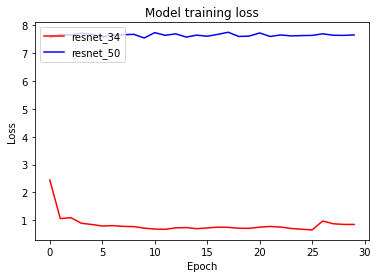

In [27]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

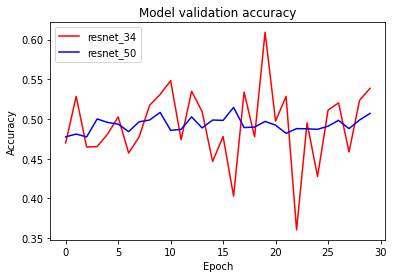

In [28]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

https://hwanny-yy.tistory.com/12  
https://github.com/tensorpack/tensorpack/blob/master/examples/ResNet/resnet_model.py